<a href="https://colab.research.google.com/github/muthu-selvakumar/AIML-course/blob/Assignment_loan_approval/Assignement_on_Loan_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Data Loading and Cleaning

In [2]:
import pandas as pd

In [11]:
filepath="/content/Loan.csv"
df = pd.read_csv('Loan.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [12]:
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])

In [13]:
# Drop unnecessary column
df = df.drop('Loan_ID', axis=1)

In [9]:
# Map target variable
df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})

In [14]:
# Encode categorical variables
cat_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)



Explanation

Missing Values: Filled categorical features with mode and numerical features (LoanAmount, Loan_Amount_Term) with median. Credit_History (0/1) filled with mode (1). Encoding: Used one-hot encoding for categorical variables to prepare for modeling. Target 'Loan_Status' mapped to 1 (Y) and 0 (N). After cleaning, no missing values remain. Dataset shape: (614, 15).

2. Exploratory Data Analysis (EDA)

In [17]:
print(df.describe())

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  614.000000        614.000000   
mean       5403.459283        1621.245798  145.752443        342.410423   
std        6109.041673        2926.248369   84.107233         64.428629   
min         150.000000           0.000000    9.000000         12.000000   
25%        2877.500000           0.000000  100.250000        360.000000   
50%        3812.500000        1188.500000  128.000000        360.000000   
75%        5795.000000        2297.250000  164.750000        360.000000   
max       81000.000000       41667.000000  700.000000        480.000000   

       Credit_History  
count      614.000000  
mean         0.855049  
std          0.352339  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


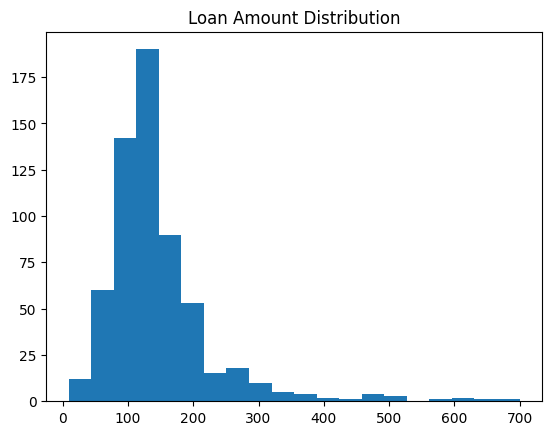

In [19]:
#Visualizations
import matplotlib.pyplot as plt

# Distribution of LoanAmount
plt.hist(df['LoanAmount'], bins=20)
plt.title('Loan Amount Distribution')
plt.show()
## Description: Right-skewed, most loans between 100-200.

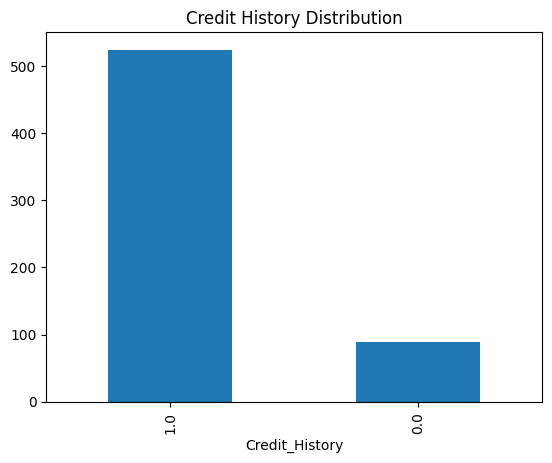

In [21]:
# Bar plot for Credit_History
df['Credit_History'].value_counts().plot(kind='bar')
plt.title('Credit History Distribution')
plt.show()
# Description: Majority (525) have credit history=1, minority (89) have 0.

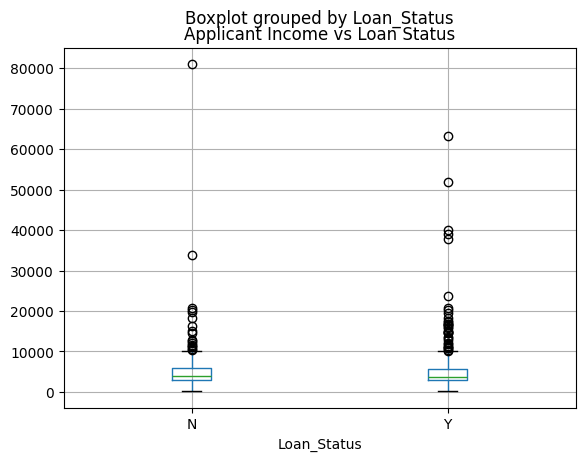

In [26]:
# Approval rate vs. features (e.g., boxplot for income vs status)
df.boxplot(column='ApplicantIncome', by='Loan_Status')
plt.title('Applicant Income vs Loan Status')
plt.show()
# Description: Similar medians, but approved have more outliers in high income

In [30]:
#Correlation and Feature Importance
# Ensure 'Loan_Status' is numeric if it's still an object type
# This handles cases where the mapping cell might not have been run yet.
if df['Loan_Status'].dtype == 'object':
    df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})

print(df.corr()['Loan_Status'].sort_values(ascending=False))

Loan_Status                1.000000
Credit_History             0.540556
Property_Area_Semiurban    0.136540
Married_Yes                0.091478
Dependents_2               0.062384
Gender_Male                0.017987
Self_Employed_Yes         -0.003700
ApplicantIncome           -0.004710
Loan_Amount_Term          -0.022549
Dependents_3+             -0.026123
LoanAmount                -0.033214
Dependents_1              -0.038740
Property_Area_Urban       -0.043621
CoapplicantIncome         -0.059187
Education_Not Graduate    -0.085884
Name: Loan_Status, dtype: float64




Key Insights:

Credit_History (0.54): Strongest positive correlation. Property_Area_Semiurban (0.14): Higher approval in semiurban areas. Married_Yes (0.09): Married applicants slightly higher approval. Education_Not Graduate (-0.09): Graduates have higher approval. Negative correlations for LoanAmount, CoapplicantIncome (minor).


Approval Rates vs. Features

In [31]:
print(df.groupby('Credit_History')['Loan_Status'].mean())
print(df.groupby('Property_Area_Semiurban')['Loan_Status'].mean())
print(df.groupby('Married_Yes')['Loan_Status'].mean())

Credit_History
0.0    0.078652
1.0    0.790476
Name: Loan_Status, dtype: float64
Property_Area_Semiurban
False    0.637795
True     0.768240
Name: Loan_Status, dtype: float64
Married_Yes
False    0.629108
True     0.718204
Name: Loan_Status, dtype: float64


Insights: Credit history is crucial for approval. Semiurban properties and married applicants have higher rates. Income distributions are suddenly changed, suggesting potential log transformation if needed, but not applied here.

3. Modeling

Data Preparation for Modeling

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Shape of X (features):", X.shape)
print("\nColumns in X:")
print(X.columns.tolist())
print("\nFirst 3 rows of X (preview):")
print(X.head(3))

Shape of X (features): (614, 14)

Columns in X:
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Gender_Male', 'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban']

First 3 rows of X (preview):
   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0       128.0             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   

   Credit_History  Gender_Male  Married_Yes  Dependents_1  Dependents_2  \
0             1.0         True        False         False         False   
1             1.0         True         True          True         False   
2             1.0         True         True         False         False   

   Dependents_3+  Education_Not Graduate  Self_Employed_Yes  \
0   

Building Models

5 models: Logistic Regression, KNN, SVM, Decision Tree, Random Forest.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

4. Evaluation

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, name):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name}:')
    print('Confusion Matrix:\n', cm)
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1-Score: {f1:.4f}\n')

for name, model in models.items():
    evaluate_model(model, name)

Logistic Regression:
Confusion Matrix:
 [[18 25]
 [ 1 79]]
Accuracy: 0.7886
Precision: 0.7596
Recall: 0.9875
F1-Score: 0.8587

KNN:
Confusion Matrix:
 [[17 26]
 [ 3 77]]
Accuracy: 0.7642
Precision: 0.7476
Recall: 0.9625
F1-Score: 0.8415

SVM:
Confusion Matrix:
 [[18 25]
 [ 0 80]]
Accuracy: 0.7967
Precision: 0.7619
Recall: 1.0000
F1-Score: 0.8649

Decision Tree:
Confusion Matrix:
 [[20 23]
 [17 63]]
Accuracy: 0.6748
Precision: 0.7326
Recall: 0.7875
F1-Score: 0.7590

Random Forest:
Confusion Matrix:
 [[18 25]
 [ 2 78]]
Accuracy: 0.7805
Precision: 0.7573
Recall: 0.9750
F1-Score: 0.8525

